# Gender Classification

<p>This notebook contain evaluation part of Gender Classification</p>
<p>Before running this notebook, please ensure that previous gender_classification.ipnby has been completed so that all required files already downloaded and generated</p>

In [27]:
import torch
from torchvision import models
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# setup default folders for storing dataset, model state and reports
# this variables should have same values as defined in gender_classifications.ipnby
data_path='./Dataset/Dataset5K' # dataset
model_path='./Models' # model state
eval_path='./Evaluation/Training' # training evaluation report

In [12]:
clean_dataset = os.path.join(data_path, 'clean_dataset.csv')
if not os.path.exists(clean_dataset):
    raise FileNotFoundError(f'''Clean dataset "{clean_dataset}" does not exist, 
        please run gender_classifications.ipnby and ensure data_path variable is assigned correctly''')
data = pd.read_csv(clean_dataset)
data.head(), data.shape

(     Filename  Male
 0  000051.jpg     1
 1  000052.jpg     1
 2  000065.jpg     1
 3  000166.jpg     1
 4  000198.jpg     0,
 (4998, 2))

## Split data with the same random_state to get consisten test_data 

In [13]:
# split the data into train and test sets with a 70:15:15 ratio
# First split: train (70%) and temp (30%)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)

# Second split: split temp (30%) into val (15%) and test (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

df.shape, train_data.shape, test_data.shape, val_data.shape

((4998, 2), (3498, 2), (750, 2), (750, 2))

In [28]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])

        # please define image convertion technique to RGB here
        image = Image.open(image_path).convert('RGB')

        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [29]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Same as training
                         std=[0.229, 0.224, 0.225])
])

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=test_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

In [15]:
# list best model state for each architecture
model_names = os.listdir(model_path)
model_names

['googlenet_5k_best.pth',
 'googlenet_pt_5k_best.pth',
 'resnet18_5k_best.pth',
 'resnet18_pt_5k_best.pth',
 'vgg16_5k_best.pth',
 'vgg16_pt_5k_best.pth']

# Train Result
<li><b>resnet18_5k_best.pth</b>: ResNet18 with dataset 5K images</li>
<li><b>resnet18_pt_5k_best.pth</b>: ResNet18 pre-trained with dataset 5K images</li>
<li><b>googlenet_5k_best.pth</b>: GoogleNet with dataset 5K images</li>
<li><b>googlenet_pt_5k_best.pth</b>: GoogleNet pre-trained with dataset 5K images</li>
<li><b>vgg16_5k_best.pth</b>: VGG16 with dataset 5K images</li>
<li><b>vgg16_pt_5k_best.pth</b>: VGG16 pre-trained with dataset 5K images</li>

## Training vs Validation Accuracy Result

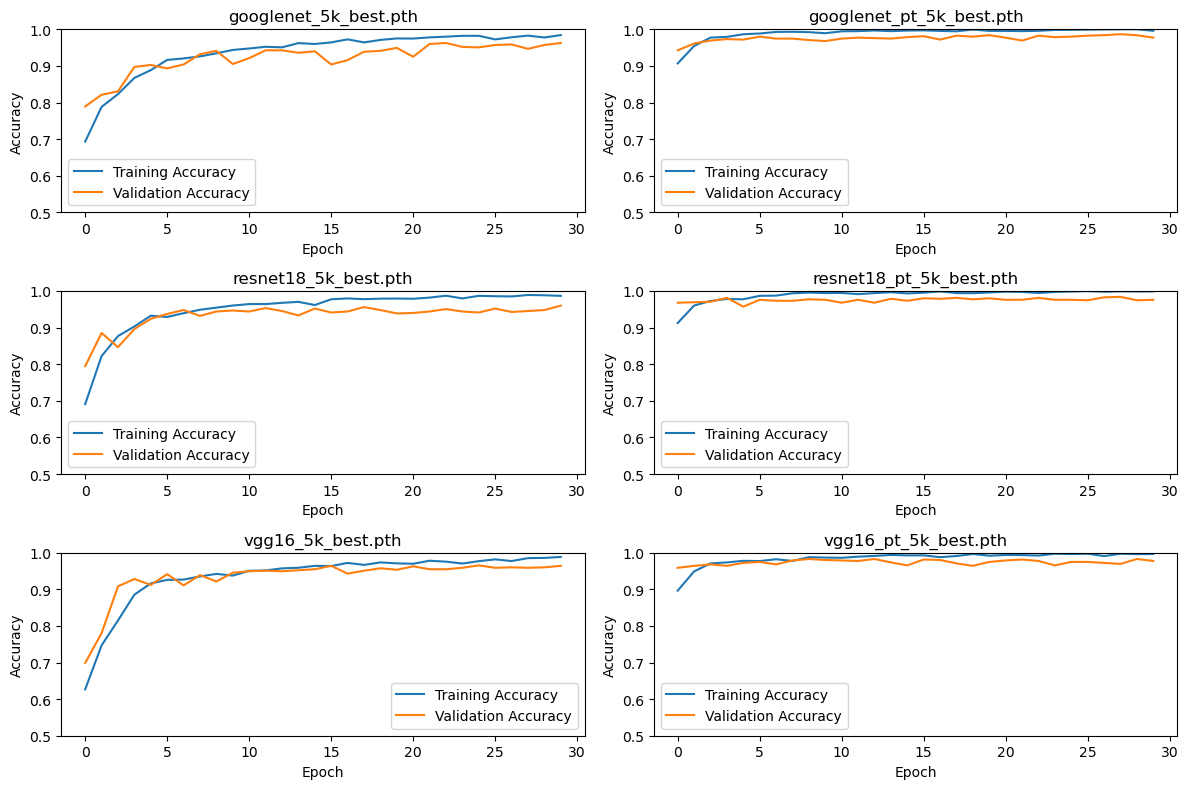

In [16]:
# Set up subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.flatten()  # flatten 2x2 grid to list for easy indexing

for idx, model_name in enumerate(model_names):
    model_state_path = os.path.join(model_path, model_name)
    if not os.path.exists(model_state_path):
        raise FileNotFoundError(f"Model not found: {model_state_path}. Please run model training first.")

    model_acc_path = os.path.join(eval_path, model_name + '_train_acc.csv')
    if not os.path.exists(model_acc_path):
        raise FileNotFoundError(f"Training accuracy history not found: {model_acc_path}. Please run model training first.")

    # Load accuracy data
    df_acc = pd.read_csv(model_acc_path)

    # Plot on subplot
    ax = axs[idx]
    ax.plot(df_acc['train'], label='Training Accuracy')
    ax.plot(df_acc['test'], label='Validation Accuracy')
    ax.set_title(model_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0.5, 1.0)
    ax.legend()

plt.tight_layout()
plt.show()

## Training Summary

In [18]:
all_summaries = []

for model_name in model_names:
    model_sum_path = os.path.join(eval_path, model_name + '_train_sum.csv')
    if not os.path.exists(model_sum_path):
        raise FileNotFoundError(f"Training summary not found: {model_sum_path}. Please run model training first.")
    
    df_sum = pd.read_csv(model_sum_path)
    
    all_summaries.append(df_sum)

# Combine all summaries into one DataFrame
df_combined = pd.concat(all_summaries, ignore_index=True)
df_combined['training_time'] = df_combined['time_elapsed'].apply(
    lambda x: f"{int(x // 60)}m {int(x % 60)}s"
)

print(df_combined)

   Unnamed: 0                     model                              device  \
0           0     googlenet_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   
1           0  googlenet_pt_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   
2           0      resnet18_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   
3           0   resnet18_pt_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   
4           0         vgg16_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   
5           0      vgg16_pt_5k_best.pth  NVIDIA GeForce RTX 4060 Laptop GPU   

   time_elapsed  best_epoch  best_acc training_time  
0    556.602479          22    0.9627        9m 16s  
1    559.801942          27    0.9867        9m 19s  
2    510.878319          29    0.9600        8m 30s  
3    507.968864          27    0.9840        8m 27s  
4   3407.822556          24    0.9653       56m 47s  
5   3388.834430           8    0.9827       56m 28s  


In [23]:
def evaluate_model(model, test_loader, class_names, device=None):
    """
    Enhanced evaluation with prediction timing and comprehensive sklearn metrics
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader for test set
        class_names: List of class names (e.g., ["female", "male"])
        device: Device to run evaluation on (auto-detects if None)
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    model.eval()
    
    total_samples = 0
    correct = 0
    all_preds = []
    all_labels = []
    total_time = 0.0  # For timing measurement
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Start timer
            start_time = time.time()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # End timer
            batch_time = time.time() - start_time
            total_time += batch_time
            
            total_samples += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = correct / total_samples
    avg_time_per_sample = (total_time / total_samples) * 1000  # Convert to milliseconds
    
    print(f'\nEvaluation Results:')
    print(f'- Accuracy: {accuracy:.4f}')
    print(f'- Total samples: {total_samples}')
    print(f'- Total prediction time: {total_time:.4f} seconds')
    print(f'- Average time per sample: {avg_time_per_sample:.2f} ms')
    
    # Additional sklearn metrics
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\nAdditional Metrics:")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall (Sensitivity): {recall:.4f}")
    print(f"- Specificity: {specificity:.4f}")
    print(f"- F1 Score: {f1_score:.4f}")
    
    return {
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'total_time': total_time,
        'avg_time_per_sample': avg_time_per_sample,
        'classification_report': classification_report(all_labels, all_preds, target_names=class_names, output_dict=True),
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1_score
    }

In [33]:
map_location='cpu'
if torch.cuda.is_available():
    map_location='cuda'

GoogleNet with Default Weight (No Freeze Layer)

Evaluation Results:
- Accuracy: 0.9440
- Total samples: 750
- Total prediction time: 0.1735 seconds
- Average time per sample: 0.23 ms

Classification Report:
              precision    recall  f1-score   support

      female       0.99      0.92      0.95       454
        male       0.89      0.98      0.93       296

    accuracy                           0.94       750
   macro avg       0.94      0.95      0.94       750
weighted avg       0.95      0.94      0.94       750


Confusion Matrix:
[[417  37]
 [  5 291]]


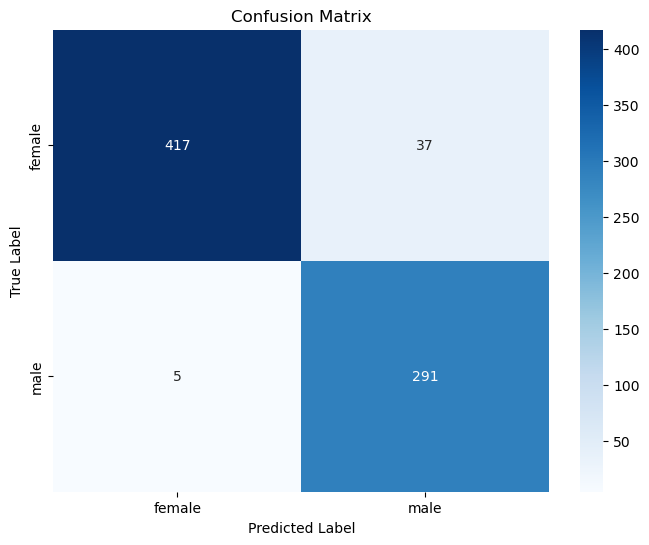


Additional Metrics:
- Precision: 0.8872
- Recall (Sensitivity): 0.9831
- Specificity: 0.9185
- F1 Score: 0.9327


In [38]:
model_name = 'GoogleNet with Default Weight (No Freeze Layer)'
model_state_weight = 'googlenet_5k_best.pth'

model = models.googlenet(aux_logits=False, init_weights=False)  # replace with your actual model, e.g., models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
try:
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
except:
    # Fallback for older PyTorch versions or complex checkpoints
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location='cuda')
model.load_state_dict(checkpoint['model'])
print(model_name)
eval_result = evaluate_model(model,test_loader, ["female", "male"])

GoogleNet Pre-Trained with ImageNet Dataset

Evaluation Results:
- Accuracy: 0.9760
- Total samples: 750
- Total prediction time: 0.1800 seconds
- Average time per sample: 0.24 ms

Classification Report:
              precision    recall  f1-score   support

      female       0.98      0.98      0.98       454
        male       0.96      0.98      0.97       296

    accuracy                           0.98       750
   macro avg       0.97      0.98      0.97       750
weighted avg       0.98      0.98      0.98       750


Confusion Matrix:
[[443  11]
 [  7 289]]


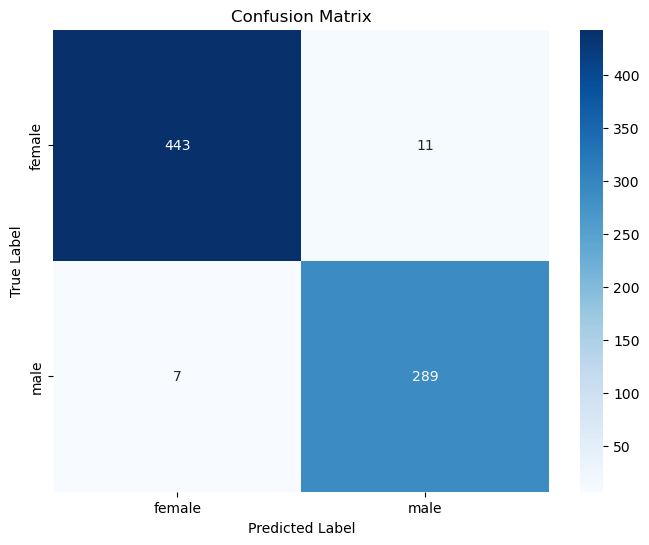


Additional Metrics:
- Precision: 0.9633
- Recall (Sensitivity): 0.9764
- Specificity: 0.9758
- F1 Score: 0.9698


In [44]:
model_name = 'GoogleNet Pre-Trained with ImageNet Dataset'
model_state_weight = 'googlenet_pt_5k_best.pth'

model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)  # replace with your actual model, e.g., models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
try:
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
except:
    # Fallback for older PyTorch versions or complex checkpoints
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location='cuda')
model.load_state_dict(checkpoint['model'])
print(model_name)
eval_result = evaluate_model(model,test_loader, ["female", "male"])

ResNet18 with Default Weight (No Freeze Layer)

Evaluation Results:
- Accuracy: 0.9573
- Total samples: 750
- Total prediction time: 0.2995 seconds
- Average time per sample: 0.40 ms

Classification Report:
              precision    recall  f1-score   support

      female       0.98      0.95      0.96       454
        male       0.92      0.97      0.95       296

    accuracy                           0.96       750
   macro avg       0.95      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750


Confusion Matrix:
[[430  24]
 [  8 288]]


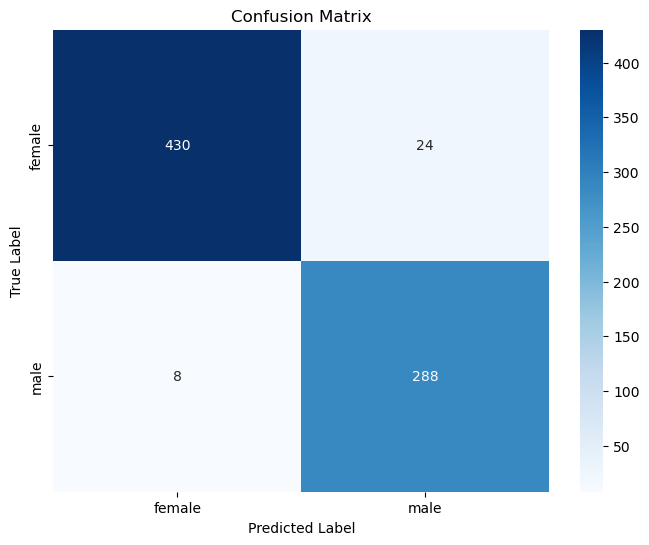


Additional Metrics:
- Precision: 0.9231
- Recall (Sensitivity): 0.9730
- Specificity: 0.9471
- F1 Score: 0.9474


In [42]:
model_name = 'ResNet18 with Default Weight (No Freeze Layer)'
model_state_weight = 'resnet18_5k_best.pth'

model = models.resnet18()  # replace with your actual model, e.g., models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
try:
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
except:
    # Fallback for older PyTorch versions or complex checkpoints
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location='cuda')
model.load_state_dict(checkpoint['model'])
print(model_name)
eval_result = evaluate_model(model,test_loader, ["female", "male"])

ResNet18 Pre-Trained with ImageNet Dataset

Evaluation Results:
- Accuracy: 0.9853
- Total samples: 750
- Total prediction time: 0.0795 seconds
- Average time per sample: 0.11 ms

Classification Report:
              precision    recall  f1-score   support

      female       0.99      0.99      0.99       454
        male       0.98      0.98      0.98       296

    accuracy                           0.99       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.99      0.99      0.99       750


Confusion Matrix:
[[448   6]
 [  5 291]]


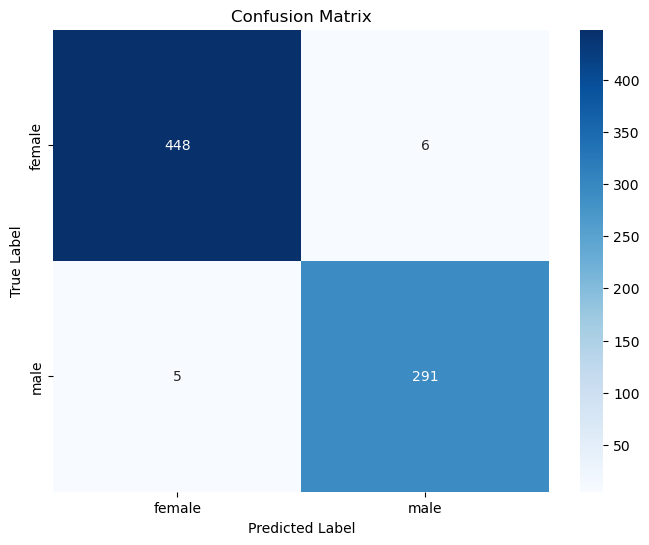


Additional Metrics:
- Precision: 0.9798
- Recall (Sensitivity): 0.9831
- Specificity: 0.9868
- F1 Score: 0.9815


In [46]:
model_name = 'ResNet18 Pre-Trained with ImageNet Dataset'
model_state_weight = 'resnet18_pt_5k_best.pth'

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # replace with your actual model, e.g., models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # for 2 output classes: male/female
try:
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location, weights_only=True)
except:
    # Fallback for older PyTorch versions or complex checkpoints
    checkpoint = torch.load(os.path.join(model_path, model_state_weight), map_location='cuda')
model.load_state_dict(checkpoint['model'])
print(model_name)
eval_result = evaluate_model(model,test_loader, ["female", "male"])

In [ ]:
model = models.vgg16()  # replace with your actual model, e.g., models.resnet18()
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)  # for 2 output classes: male/female
checkpoint = torch.load(os.path.join(model_path, 'vgg_5k_best.pth'), map_location='cuda')  # or 'cuda' if using GPU
model.load_state_dict(checkpoint['model'])
print('Model VGG16')
accuracy, all_preds, all_labels, total_time, avg_time_per_sample = evaluate_model(model,test_loader, ["female", "male"])